## Structure Learning Notebook

In [14]:
%matplotlib inline
import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx
import itertools

from numpy.random import random, choice
from metal.label_model.utils import visualize_matrix


### Recovering a tree + Y 

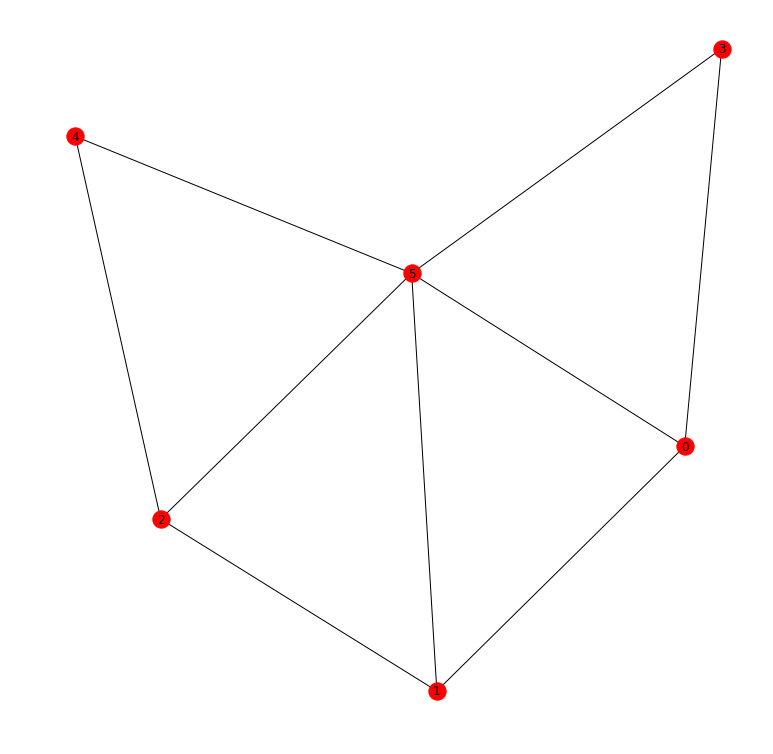

In [24]:
# generate a tree
m = 5

G = nx.random_tree(m)
for i in range(m):
    # Y is connected to everything
    G.add_edge(i,m)
    
# simple exponential model for the graph

# binary Ising model defined over LF nodes (m), the LF edges (m-1),
#  Y (1), and (Y,LF) edges (m)

t = {}
for node in G.nodes(): t[node] = random() 
for edge in G.edges(): t[edge] = random()

# graph:
nx.draw(G, pos=nx.spring_layout(G), with_labels=True)

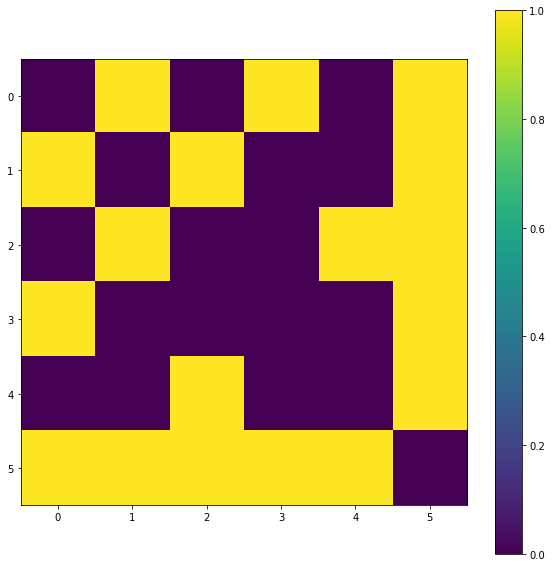

In [25]:
# adjacency matrix visualization:
visualize_matrix(nx.adjacency_matrix(G).todense())

In [29]:
# simple utilities 
def _exp_model(x, t):
    sm = 0
    for node in G.nodes():
        sm += x[node] * t[node]
    for edge in G.edges():
        sm += x[edge[0]] * x[edge[1]] * t[edge]
        
    return np.exp(sm)

def _model_sum(x_set, t):
    # x_set contains active variables
    x_un = set.union(*x_set) if x_set else set()
    
    marg_set = set(range(m+1)) - x_un
    marg_set_sz = len(marg_set)
    
    sm = 0
    combs = list(itertools.product([0, 1], repeat=marg_set_sz))
    for l in combs:
        x = np.ones([m+1])
        x[ list(marg_set) ] = l
        sm += _exp_model(x, t)
        
    return sm

# partition function
Z = _model_sum(set(), t)

def prob(x_set, t):
    return _model_sum(x_set, t) / Z

## Structure Check:

In [30]:
def clique_to_set(cl1):
    xs = set()
    if isinstance(cl1, int): 
        xs.add(cl1)
    else:
        xs = set.union(xs, set(cl1))
    return xs

# Generate the full augmented covariance matrix that contains all separators
side_cov = len(t)
S_aug = np.zeros([side_cov, side_cov])
O_aug = np.zeros([side_cov, side_cov])
mu_aug = np.zeros([side_cov, 1])

i1 = 0
i2 = 0
for clique1 in t.keys():
    i2 = 0
    for clique2 in t.keys():
        x_set = [clique_to_set(clique1), clique_to_set(clique2)]
        O_aug[i1, i2] = prob(x_set, t)
        i2 += 1
    i1 += 1

i1 = 0
for clique1 in t.keys():
    x_set = [clique_to_set(clique1)]
    mu_aug[i1] = prob(x_set, t)
    i1 += 1
    
S_aug = O_aug - np.outer(mu_aug, mu_aug)

S_aug_inv = np.linalg.inv(S_aug)

# nodes 2 and 3 don't have an edge, check that this is 0
S_aug_inv[2,3]

-8.060793617464171e-13

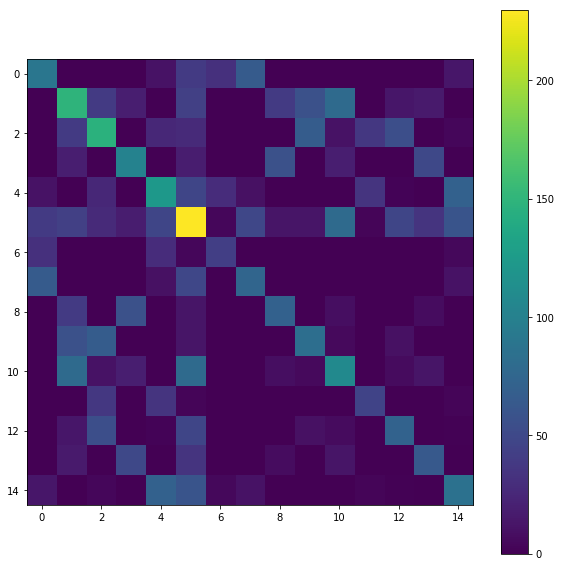

In [18]:
# visualize the 'full' inverse covariance matrix
# note: for structure learning we'd be forming an even bigger graph!
visualize_matrix(np.abs(S_aug_inv))

## Supervised Structure Learning

In [ ]:
# key idea: we don't know any edges except the (Y,LF) ones